In [4]:
library(quantstrat)
library(quantmod)
library(riingo)
library(xts)
library(tbl2xts)

In [5]:
startDate = "2004-01-01"; endDate = "2019-05-01"
Sys.setenv(TZ="UTC")
xleHist <- riingo_prices("XLE", resample_frequency = "daily", 
                         start_date = startDate,
                         end_date = endDate)
xleHist <- tbl_xts(xleHist)
  
XLE <- xleHist[,c('adjOpen','adjHigh','adjLow','adjClose','adjVolume')]
names(XLE) <- c('XLE.Open','XLE.High','XLE.Low','XLE.Close','XLE.Volume')

Warning message:
“'glue::collapse' is deprecated.
Use 'glue_collapse' instead.
See help("Deprecated") and help("glue-deprecated").”

In [7]:
# initialize strategy
qs.strategy <- "qsClenow" 

# initialize currencies / dates
currency("USD"); stock("XLE", currency="USD", multiplier=1)
initEq <- 1e6; initDate="2003-12-31"

# order size fills to $500k
osFixedDollar <- function(timestamp, orderqty, orderside, ...){
  ClosePrice <- as.numeric(Cl(mktdata[timestamp,]))
  orderqty <- round(5e5 / ClosePrice, -2)
  
  if(orderside == "short"){
    orderqty <- -1*orderqty
  }
  
  return(orderqty)
}

# initialize Portfolio / Account / Order Container
initPortf(name=qs.strategy, symbols='XLE', 
          initDate=initDate, currency="USD")
initAcct(name=qs.strategy, portfolios=qs.strategy, 
         initDate=initDate, initEq=initEq)
initOrders(portfolio=qs.strategy, 
           initDate=initDate)
strategy(name=qs.strategy, store=TRUE)

# indicators
add.indicator(strategy=qs.strategy, name="SMA",
              arguments=list(x=quote(Cl(XLE)), n=fast),
              label="SMA_fast")
add.indicator(strategy=qs.strategy, name="SMA",
              arguments=list(x=quote(Cl(XLE)), n=slow),
              label="SMA_slow")

# signals
add.signal(qs.strategy, name="sigCrossover",
           arguments=list(columns=c("SMA_fast","SMA_slow"),relationship="gt"),
           label="fast.gt.slow")
add.signal(qs.strategy, name="sigCrossover",
           arguments=list(columns=c("SMA_fast","SMA_slow"),relationship="lt"),
           label="fast.lt.slow")

# rules
add.rule(qs.strategy, name="ruleSignal",
         arguments=list(sigcol="fast.gt.slow", sigval=TRUE,
                        ordertype='market', orderside='long', pricemethod='market',
                        TxnFees=0, replace=FALSE, osFUN='osFixedDollar'),
         type='enter', path.dep=TRUE)

add.rule(qs.strategy, name="ruleSignal",
         arguments=list(sigcol="fast.gt.slow", sigval=TRUE, orderqty='all',
                        ordertype='market', orderside='short', pricemethod='market',
                        TxnFees=0, replace=FALSE),
         type='exit', path.dep=TRUE)

add.rule(qs.strategy, name="ruleSignal",
         arguments=list(sigcol="fast.lt.slow", sigval=TRUE,
                        ordertype='market', orderside='short', pricemethod='market',
                        TxnFees=0, replace=FALSE, osFUN='osFixedDollar'),
         type='enter', path.dep=TRUE)

add.rule(qs.strategy, name="ruleSignal",
         arguments=list(sigcol="fast.lt.slow", sigval=TRUE, orderqty='all',
                        ordertype='market', orderside='long', pricemethod='market',
                        TxnFees=0, replace=FALSE),
         type='exit', path.dep=TRUE)

[1] "USD"

[1] "XLE"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

In [8]:
applyStrategy(qs.strategy, portfolio=qs.strategy, mktdata=XLE)

[1] "2005-05-19 00:00:00 XLE -16900 @ 30.1300529522"
[1] "2005-06-02 00:00:00 XLE 16900 @ 31.9702864742"
[1] "2005-06-02 00:00:00 XLE 15600 @ 31.9702864742"
[1] "2005-10-24 00:00:00 XLE -15600 @ 36.1569153321"
[1] "2005-10-24 00:00:00 XLE -14300 @ 36.1569153321"
[1] "2005-11-07 00:00:00 XLE 14300 @ 36.9003852655"
[1] "2005-11-07 00:00:00 XLE 13300 @ 36.9003852655"
[1] "2005-11-15 00:00:00 XLE -13300 @ 36.2631253226"
[1] "2005-11-15 00:00:00 XLE -13800 @ 36.2631253226"
[1] "2005-11-28 00:00:00 XLE 13800 @ 37.3859166505"
[1] "2005-11-28 00:00:00 XLE 12900 @ 37.3859166505"
[1] "2006-05-26 00:00:00 XLE -12900 @ 42.0392877574"
[1] "2006-05-26 00:00:00 XLE -11900 @ 42.0392877574"
[1] "2006-07-06 00:00:00 XLE 11900 @ 44.0105668545"
[1] "2006-07-06 00:00:00 XLE 11300 @ 44.0105668545"
[1] "2006-09-12 00:00:00 XLE -11300 @ 39.7833469304"
[1] "2006-09-12 00:00:00 XLE -12500 @ 39.7833469304"
[1] "2006-10-26 00:00:00 XLE 12500 @ 43.5209324113"
[1] "2006-10-26 00:00:00 XLE 11500 @ 43.5209324113"
[1]

In [9]:
updatePortf(qs.strategy)
updateAcct(qs.strategy)
updateEndEq(qs.strategy)

[1] "qsClenow"

[1] "qsClenow"

[1] "qsClenow"

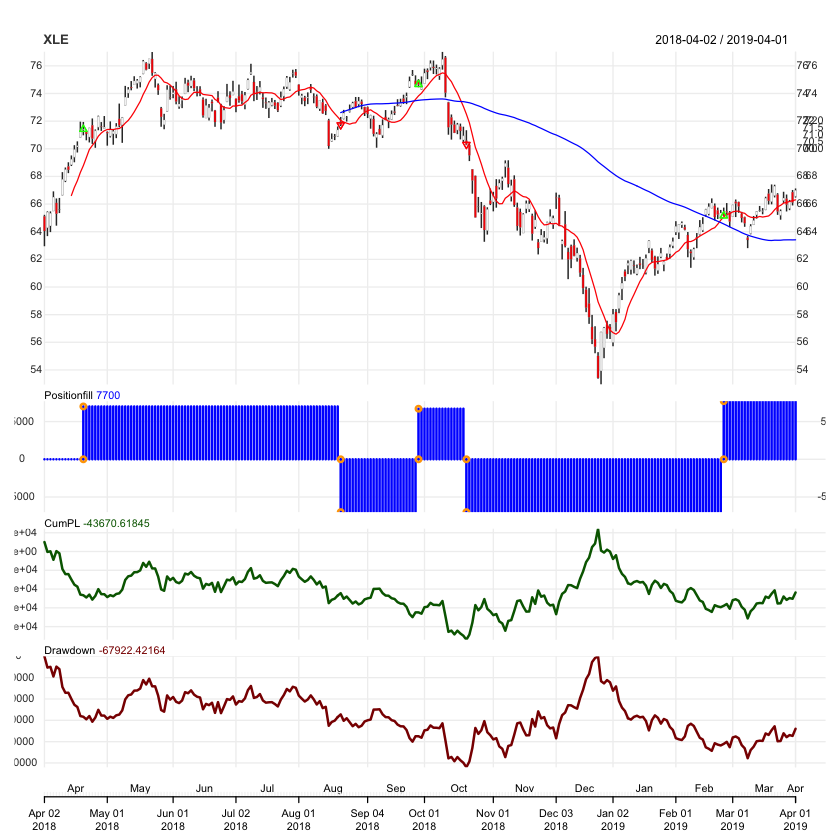

In [10]:
chart.Posn(Portfolio=qs.strategy, Symbol="XLE",
           TA="add_SMA(n=fast,col='red',on=1); add_SMA(n=slow,col='blue',on=1)",
           Dates="2018-04-01::2019-04-01")